# Figure 4

In [2]:
## Basics
import numpy as np
import pandas as pd
import glob
import mdtraj as md
import random
from scipy import stats
from scipy.special import logit

## Bio functions
from Bio import AlignIO
from Bio import SeqIO

## Local functions
import sys
sys.path.append("../code/scripts")
import alignment_quality as aq
import chargepatterns as cp
import composition as comp
import crutil
import fractional_charge as fc


## Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

## Set seed for consistency
### In the future when writing code with random remember to use new methods which explicitly create generators
seed = 212121

In [3]:
def comp_to_dict(c):
    d = {}
    for i,aa in enumerate(comp.aas):
        d[aa] = c[i]
    return d

## A

## B

In [4]:
aybrah = ['Rhodotorula graminis',
        'Saitoella complicata',
        'Schizosaccharomyces pombe',
        'Aspergillus niger',
        'Neurospora crassa',
        'Trichoderma reesei',
        'Lipomyces starkeyi',
        'Yarrowia lipolytica',
        'Blastobotrys adeninivorans',
        'Nadsonia fulvescens',
        'Ascoidea rubescens',
        'Pachysolen tannophilus',
        'Komagataella phaffii',
        'Kuraishia capsulata',
        'Ogataea arabinofermentans',
        'Ogataea parapolymorpha',
        'Dekkera bruxellensis',
        'Pichia membranifaciens',
        'Pichia kudriavzevii',
        'Babjeviella inositovora',
        'Metschnikowia bicuspidata',
        'Meyerozyma guilliermondii',
        'Debaryomyces hansenii',
        'Scheffersomyces stipitis',
        'Spathaspora passalidarum',
        'Wickerhamomyces anomalus',
        'Cyberlindnera jadinii',
        'Hanseniaspora valbyensis',
        'Kluyveromyces lactis',
        'Lachancea thermotolerans',
        'Zygosaccharomyces rouxii',
        'Saccharomyces cerevisiae',
        'Vanderwaltozyma polyspora']

In [5]:
AA_groups = {'charged': ['R', 'K', 'D', 'E', 'H'],
             'polar': ['Q', 'N', 'S', 'T', 'G'],
             'nonpolar': ['M', 'V', 'I', 'L'],
             'aromatic': ['F', 'Y', 'W'],
             'small': ['P', 'A', 'C']}

In [6]:
comp_dict = {}
for species in aybrah:
    name = species.split(' ')
    filepath = '../data/ref_proteomes/' + name[0] + '_' + name[1] + '.fasta'
    prot = []
    for record in SeqIO.parse(filepath, "fasta"):
        prot.append(record)
    
    c = np.zeros(20)
    for orf in prot:
        seq = str(orf.seq).replace('*', '').replace('X', '')
        c = np.add(c, comp.get_composition(seq, comp.aas))
    c = np.divide(c, len(prot))
    d = comp_to_dict(c)
    comp_dict[species] = d

In [7]:
df = pd.DataFrame(columns = ['species', 'AA_group', 'proportion', 'log.odds'])
for species in aybrah:
    c = comp_dict[species]
    for group, AAs in AA_groups.items():
        rv = {}
        if species == 'Saccharomyces cerevisiae':
            rv = {'species': species}
        else:
            rv = {'species': 'others'}
        rv['AA_group'] = group
        rv['proportion'] = 0
        for AA in AAs:
            rv['proportion'] += c[AA]
        rv['log.odds'] = logit(rv['proportion'])
        df = df.append(rv, ignore_index=True)

def apply_color_label(row):
    if row['AA_group'] == 'charged':
        return('charged')
    else:
        return('other')
        
        
df['color_label'] = df.apply(apply_color_label, axis=1)

In [8]:
df_sc = df[df.species == 'Saccharomyces cerevisiae']
df_nonsc = df[df.species != 'Saccharomyces cerevisiae']

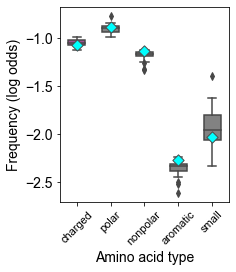

In [11]:
plt.figure(figsize=(3.5,4))
sns.boxplot(x="AA_group", y="log.odds", data=df, hue='color_label', palette=[cscheme["cr"], cscheme["dis"]],
           dodge=False, width=0.5)
#sns.swarmplot(x="AA_group", y="proportion", hue="species", data=df, edgecolor = '.3', linewidth=1, alpha=0.8,
#              size=6, palette={'Saccharomyces cerevisiae': 'cyan', 'others':'.3'})
#sns.swarmplot(x="AA_group", y="log.odds", data=df_nonsc,
#              color = '.3', linewidth=1, alpha=0.8, size=5)
sns.swarmplot(x="AA_group", y="log.odds", data=df_sc,
              color = 'cyan', linewidth=1, size=8, marker = 'D')
plt.ylabel('Frequency (log odds)', fontsize=14)
plt.xticks(rotation = 45)
plt.xlabel('Amino acid type', fontsize=14)
plt.xticks(fontsize=11)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('./plots/Figure3.4B.png', dpi=300)
plt.show()

## C

In [5]:
# Data and filepaths
df = pd.read_csv("../data/charged_regions/cr_filtered.csv", comment='#')

#aybrah_path = '/Volumes/DATA/aybrah/hits_outputs/20210218/'
#aybrah_path = '/mnt/d/research/drummond-lab/data/aybrah-all/'
aybrah_path = "/Volumes/DATA/aybrah/aybrah-all/"

fdir = "/Volumes/DATA/aybrah/aybrah-all/"
#fdir = '/mnt/d/research/drummond-lab/data/aybrah-all/'

In [6]:
# Helper functions

def filter_msa(msa, cutoff, how="length"):
    """
    Given an msa, filter out all the entries that are less than a certain length.
    """
    filtered_msa = []
    for record in msa:
        rlen = len(str(record.seq).replace('-', ''))
        if rlen > cutoff:
            filtered_msa.append(record)
            
    return(filtered_msa)

def COV(x, absolute=True):
    """
    Given a interable of values, return the coefficient of variation of those values.
    """
    std = np.sqrt(np.nanvar(x))
    if not absolute:
        return(std / np.nanmean(x))
    else:
        return(std / np.abs(np.nanmean(x)))

In [7]:
def compute_region_fcr(msa):
    """
    Given an msa, extract the mean fraction of charged residues (FCR) of all the sequences in the msa
    """
    fcrs = []
    for record in msa:
        seq = str(record.seq).replace('-',"")
        fcrs.append(cp.fraction_charged(seq))
    return np.mean(fcrs)

def compute_region_fcr_var(msa, cov=False):
    """
    Given an msa, extract the variance in the fraction of charged residues (FCR) of all the sequences in the msa
    """
    fcrs = []
    for record in msa:
        seq = str(record.seq).replace('-',"")
        fcrs.append(cp.fraction_charged(seq))
    if not cov:
        return np.var(fcrs)
    else:
        return COV(fcrs)
    
def get_row_charge_props(row, filter_cutoff=30):
    orf = row['orf']  
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    # Read MSA for the orf in question
    msa = AlignIO.read(open(aybrah_path+str(orf)+'-aybrah.fa'), "fasta")
    # Get just the region in question
    region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)
    # Filter the msa for very short and empty regions
    region_msa = filter_msa(region_msa, cutoff=filter_cutoff)
    msa_len = len(region_msa)
    if msa_len < 10:
        out = np.empty(3)
        out[:] = np.NaN
        return pd.Series(out)
    
    # Calculate charge properties
    region_mean_fcr = compute_region_fcr(region_msa)
    region_fcr_var = compute_region_fcr_var(region_msa)
    region_fcr_cov = compute_region_fcr_var(region_msa, cov=True)
    
    return pd.Series([region_mean_fcr, region_fcr_var, region_fcr_cov])

In [8]:
newcols = df.apply(get_row_charge_props, axis=1)
newcols.columns = ['aybrah.mean.fcr', 'aybrah.fcr.var', 'aybrah.fcr.cov']
newdf = df.join(newcols)
newdf.head()

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,kappa1,kappa2,uni_id,orf_label,aybrah.mean.fcr,aybrah.fcr.var,aybrah.fcr.cov
0,YAL011W,SWC3,626,0,54,MPAVLRTRSKESSIEQKPASRTRTRSRRGKRGRDDDDDDDDEESDD...,55,0.015674,0.527273,0.297167,0.616928,P31376,verified,0.334740,0.010555,0.306915
1,YAL011W,SWC3,626,169,265,RLFILKNDKIEQKWQDEQELKKKEKELKRKNDAEAKRLRMEERKRQ...,97,0.050753,0.536082,0.051716,0.110243,P31376,verified,0.406444,0.019036,0.339458
2,YAL011W,SWC3,626,361,424,KTAATEPEPKKADDENAEKQQSKEAKTTAESTQVDVKKEEEDVKEK...,64,0.007812,0.500000,0.044964,0.096912,P31376,verified,0.391627,0.016703,0.330008
3,YAL011W,SWC3,626,470,525,KSVVEFLEDTDEIIISWIVIHNSKEIEKFKTKKIKAKLKADQKLNK...,56,0.000000,0.428571,0.114622,0.300249,P31376,verified,0.461596,0.007704,0.190149
4,YAL013W,DEP1,406,81,163,TLTESLKRPHEDEKEAIDEAKKMKVPGENEDESKEEEKSQELEEAI...,83,0.141633,0.542169,0.093375,0.239955,P31385,verified,0.499872,0.008329,0.182575


In [17]:
verified_orfs_with_msa = pd.read_csv('../data/sc_orfs/verified_orfs_with_msa.csv')
valid_orfs = verified_orfs_with_msa['systematic_name'].tolist()

np.random.seed(seed)

def extract_random_region_from_proteome(fdir, regionlen, valid_orfs):
    msa = None
    cnt = 0
    while msa is None:
        orf_i = random.randrange(len(valid_orfs))
        orf = valid_orfs[orf_i]
        msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
        if len(msa[0].seq) <= regionlen:
            msa = None
        cnt += 1
        if cnt >= 20:
            print(regionlen)
    starti = random.randrange(len(msa[0].seq) - regionlen)
    random_msa = msa[:, starti:(starti + regionlen)]    
    return random_msa

ranges_dict = {}
for index, row in df.iterrows():
    orf = row['orf']
    msa = AlignIO.read(open(aybrah_path+str(orf)+'-aybrah.fa'), "fasta")
    if orf not in ranges_dict:
        ranges_dict[orf] = []
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    msa_left_bound, msa_right_bound = aq.get_region_range(msa, left_bound, right_bound, refseq=refseq)
    ranges_dict[orf].append((msa_left_bound, msa_right_bound))

In [18]:
# add dist of randomly draw regions msas to above
np.random.seed(seed)
fcr_random = []

for k,v in ranges_dict.items():
    for charged_region in v:
        regionlen = charged_region[1] - charged_region[0] + 1
        
        # Draw a random msa and ensure there is an S. cer sequence in it
        redraw = True
        while redraw:
            #random_msa = extract_random_region_from_proteome(fdir, regionlen, valid_orfs)
            length = 0
            while length < 10:
                random_msa = extract_random_region_from_proteome(fdir, regionlen, valid_orfs)
                # Filter out empty and very short sequences as we did for the charged regions themselves
                random_msa = filter_msa(random_msa, 25)
                # Calculate how many sequences are in the resulting alignment and redraw if there are fewer than the cutoff
                length = len(random_msa)
            for record in random_msa:
                if record.id == "Saccharomyces":
                    redraw=False
                    refseq=str(record.seq).replace("-", "")
        
        random_fcr = compute_region_fcr(random_msa)
        fcr_random.append(random_fcr)

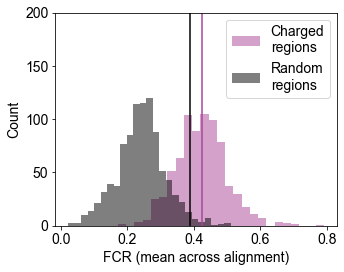

In [19]:
random_2sigma = np.mean(fcr_random) + (2*np.sqrt(np.var(fcr_random)))

plt.figure(figsize=(5,4))
plt.hist(newdf['aybrah.mean.fcr'], bins=25, label = 'Charged\nregions', color = cscheme['cr'], alpha=0.5)
plt.hist(fcr_random, bins=25, label='Random\nregions', color=cscheme['null'], alpha=0.5)
plt.vlines(x=np.mean(newdf['aybrah.mean.fcr']), ymin=0, ymax=200, color=cscheme['cr'])
plt.vlines(x=random_2sigma, ymin=0, ymax=200, color="black")
plt.xlabel("FCR (mean across alignment)")
plt.ylabel("Count")
plt.ylim((0, 200))
plt.legend()
plt.tight_layout()
plt.savefig('./plots/Figure3.4C.png', dpi=300)
plt.show()

## D

In [20]:
enriched_data_path = "../data/null-regions-output/"

In [21]:
def compute_region_enriched_fraction(msa, target_aas):
    """
    Given an msa, extract the mean fraction of amino acids in a subset (target_aaas)
    for each sequences in the msa and return the mean
    """
    fracs = []
    for record in msa:
        seq = str(record.seq).replace('-',"")
        fracs.append(fc.get_enriched_fraction(seq, target_aas))
    return np.mean(fracs)

def read_and_filter_enrichment_data(file):
    data = pd.read_csv(file, comment="#")
    
    # # Filter MSA
    wrong_seq = []
    for index, row in data.iterrows():
        orf = row['orf']
        try:
            msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
        # These are all empty / not in the Aybrah database
        except ValueError:
            wrong_seq.append(index)
            continue       
        contains_seq = False
        for record in msa:
            seq = crutil.remove_gaps(record.seq)
            if row['region.seq'] in seq:
                contains_seq = True
        if not contains_seq:
            wrong_seq.append(index)

    data.drop(data.index[wrong_seq], inplace=True)
    return data

def get_row_comp_conservation(row, target_aas, filter_cutoff=30):
    orf = row['orf']  
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    # Read MSA for the orf in question
    msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    # Get just the region in question
    # There are a small number of problematic sequences where the alignment boundaries are incorrect
    # This skips these; I still don't understand why they happen
    try:
        region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)
    except KeyError:
        return(np.nan)
    # Filter the msa for very short and empty regions
    region_msa = filter_msa(region_msa, cutoff=filter_cutoff)

    region_enrichment = compute_region_enriched_fraction(region_msa, target_aas)
    
    return pd.Series(region_enrichment)

def get_comp(seq, states):
    dcomp = {}
    for state in states:
        dcomp[state] = 0
    for aa in seq:
        dcomp[aa] += 1
    comp = []
    for k,v in dcomp.items():
        comp.append(v / len(seq))
    return comp

def get_proteome_freqs(prot_filepath):
    """
    Given a .fa formattted proteome file (located at prot_filepath), generate a frequency vector of the natural 20 amino acids (in alphabetical order)
    """
    scerprot = []
    for record in SeqIO.parse(prot_filepath, "fasta"):
        scerprot.append(record)
    
    scercomp = np.zeros(20)
    for orf in scerprot:
        seq = str(orf.seq).replace('*', '')
        scercomp = np.add(scercomp, get_comp(seq, comp.aas))
    scercomp = np.divide(scercomp, len(scerprot))

    return(dict(zip(comp.aas, scercomp)))

def scale_to_unit(value, zer_val, one_val):
    """
    Given a value (float), convert to a scaled value within a given range onto the 0->1 scale.
    """
    span = one_val - zer_val
    scaled_value = (value-zer_val) / span
    return scaled_value

In [22]:
aa_freqs = get_proteome_freqs("../data/ref_proteomes/Saccharomyces_cerevisiae.fasta")

In [17]:
## Only uncomment if you want to regenerate data -- it takes a long time!

# files = glob.glob(enriched_data_path+"*_enriched.csv")

# all_drifts = []

# for f, file in enumerate(files):
#     if f % 5 == 0:
#         print("Processing file {} / {}".format(f, len(files)))
#     data = read_and_filter_enrichment_data(file)
#     targets = list(data.keys()[-1][-4:])
#     try:
#         data["aybrah.avg.enrichment"] = data.apply(get_row_comp_conservation, args=(targets, ), axis=1)
#     except KeyError:
#         print(file)
#         continue

#     proteome_freq = np.sum([aa_freqs[aa] for aa in targets])
#     enriched_freq = np.nanmean(data["fraction.enriched.{}".format(''.join(targets))])
#     scaled_drift = scale_to_unit(np.nanmean(data['aybrah.avg.enrichment']), proteome_freq, enriched_freq)
#     all_drifts.append(1-scaled_drift)

Processing file 0 / 209
Processing file 5 / 209
Processing file 10 / 209
Processing file 15 / 209
Processing file 20 / 209
Processing file 25 / 209
Processing file 30 / 209
Processing file 35 / 209
Processing file 40 / 209
Processing file 45 / 209
Processing file 50 / 209
Processing file 55 / 209


/Users/triandafillou/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/triandafillou/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing file 60 / 209
Processing file 65 / 209
Processing file 70 / 209
Processing file 75 / 209
Processing file 80 / 209
Processing file 85 / 209
Processing file 90 / 209
Processing file 95 / 209
Processing file 100 / 209
Processing file 105 / 209
Processing file 110 / 209
Processing file 115 / 209
Processing file 120 / 209
Processing file 125 / 209
Processing file 130 / 209
Processing file 135 / 209
Processing file 140 / 209
Processing file 145 / 209
Processing file 150 / 209
Processing file 155 / 209
Processing file 160 / 209
Processing file 165 / 209
Processing file 170 / 209
Processing file 175 / 209
Processing file 180 / 209
Processing file 185 / 209
Processing file 190 / 209
Processing file 195 / 209
Processing file 200 / 209
Processing file 205 / 209


In [23]:
#np.savetxt("../data/null-regions-output/all_mean_drift_values_30.npy", all_drifts)
to_plot = np.loadtxt("../data/null-regions-output/all_mean_drift_values_30.npy")

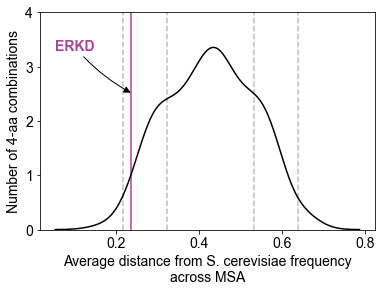

In [24]:
plt.figure(figsize=(6,4))
sns.kdeplot(to_plot, color='black')
plt.vlines(x=(1-0.7627), ymax=5, ymin=0, color=cscheme["cr"])
#plt.vlines(np.mean(to_plot), ymax=5, ymin=0)
plt.vlines((np.mean(to_plot)+np.std(to_plot)), ymax=5, ymin=0, color='gray', linestyle="dashed", alpha=0.5)
plt.vlines((np.mean(to_plot)-np.std(to_plot)), ymax=5, ymin=0, color='gray', linestyle="dashed", alpha=0.5)
plt.vlines((np.mean(to_plot)+2*np.std(to_plot)), ymax=5, ymin=0, color='gray', linestyle="dashed", alpha=0.5)
plt.vlines((np.mean(to_plot)-2*np.std(to_plot)), ymax=5, ymin=0, color='gray', linestyle="dashed", alpha=0.5)
plt.annotate('ERKD',
            xy=(0.24, 2.5), xycoords='data', size=14, weight='bold',
            xytext=(0.1, 3.5), textcoords='data',
            arrowprops=dict(color="black", arrowstyle='-|>', connectionstyle="arc3,rad=0.1"),
            horizontalalignment='center', verticalalignment='top', color=cscheme["cr"])
plt.ylim(0, 4)
plt.xlabel("Average distance from S. cerevisiae frequency\nacross MSA")
plt.ylabel("Number of 4-aa combinations")
#plt.tight_layout()
plt.show()

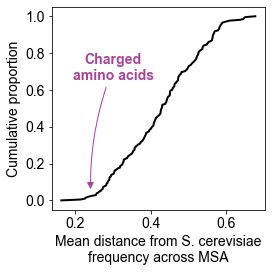

In [25]:
fig, ax = plt.subplots(figsize=(4,4))

ax.plot(np.sort(to_plot), np.linspace(0, 1, len(to_plot)), linewidth=2, color = 'black')
ax.annotate('Charged\namino acids',
            xy=(0.24, 0.05), xycoords='data', size=14, weight='bold',
            xytext=(0.3, 0.8), textcoords='data',
            arrowprops=dict(color=cscheme['cr'], arrowstyle='-|>', connectionstyle="arc3,rad=0.1"),
            horizontalalignment='center', verticalalignment='top', color=cscheme["cr"])
plt.xlabel("Mean distance from S. cerevisiae\nfrequency across MSA")
plt.ylabel("Cumulative proportion")
plt.tight_layout()
plt.show()

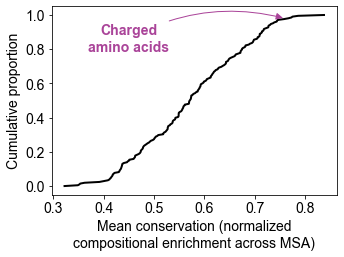

In [26]:
# Another (inverse) version with different labels
fig, ax = plt.subplots(figsize=(5,3.8))

ax.plot(np.sort(1-to_plot), np.linspace(0, 1, len(to_plot)), linewidth=2, color = 'black')
ax.annotate('Charged\namino acids',
            xy=(1-0.24, 0.98), xycoords='data', size=14, weight='bold',
            xytext=(0.45, 0.95), textcoords='data',
            arrowprops=dict(color=cscheme['cr'], arrowstyle='-|>', connectionstyle="arc3,rad=-0.2"),
            horizontalalignment='center', verticalalignment='top', color=cscheme["cr"])
plt.xlabel("Mean conservation (normalized\ncompositional enrichment across MSA)")
plt.ylabel("Cumulative proportion")
plt.tight_layout()
plt.savefig('./plots/Figure3.4E.png', dpi=300)
plt.show()

In [27]:
len(to_plot)

209

## E

In [9]:
ranges_dict = {}
for index, row in df.iterrows():
    orf = row['orf']
    msa = AlignIO.read(open(aybrah_path+str(orf)+'-aybrah.fa'), "fasta")
    if orf not in ranges_dict:
        ranges_dict[orf] = []
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    msa_left_bound, msa_right_bound = aq.get_region_range(msa, left_bound, right_bound, refseq=refseq)
    ranges_dict[orf].append((msa_left_bound, msa_right_bound))

In [10]:
def get_uncharged_region_ranges(charged_regions, msa_len):
    uncharged_regions = []
    
    if charged_regions[0][0] != 0:
        uncharged_regions.append((0, charged_regions[0][0] - 1))
        
    start = charged_regions[0][1] + 1
    for region in charged_regions[1:]:
        uncharged_regions.append((start, region[0]-1))
        start = region[1] + 1

    if charged_regions[-1][1] != (msa_len - 1):
        uncharged_regions.append((charged_regions[-1][1], msa_len-1))
        
    return uncharged_regions

In [11]:
def extract_uncharged_region_msa(msa, charged_regions):
    uncharged_regions = get_uncharged_region_ranges(charged_regions, len(msa[0]))
    for record in msa:
        uncharged_seq = ''
        for region in uncharged_regions:
            uncharged_seq += record.seq[region[0]:(region[1]+1)]
        record.seq = uncharged_seq
    return msa

In [12]:
# Robust versions of functions to handle empty and short strings when looking at the rest of the protein
def fraction_charged2(sequence):
    """
    Given a string of single-letter amino acids (sequence), return the fraction of charged residues.
    """
    sequence = sequence.upper()
    n = len(sequence)
    try:
        fc = (sequence.count('E') + sequence.count('K') + sequence.count('R') + sequence.count('D')) / n
    except ZeroDivisionError:
        return(np.nan)

    return(fc)

def compute_region_fcr2(msa):
    """
    Given an msa, extract the mean fraction of charged residues (FCR) of all the sequences in the msa
    """
    fcrs = []
    for record in msa:
        seq = str(record.seq).replace('-',"")
        if len(seq) == 0:
            continue
        fcrs.append(fraction_charged2(seq))
    return np.nanmean(fcrs)

In [13]:
def append_null_fcr(row):
    orf = row['orf']
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    charged_regions = ranges_dict[orf]
    msa = AlignIO.read(open(aybrah_path+str(orf)+'-aybrah.fa'), "fasta")
    msa_left_bound, msa_right_bound = aq.get_region_range(msa, left_bound, right_bound, refseq=refseq)
    regionlen = msa_right_bound - msa_left_bound
    uncharged_region_msa = extract_uncharged_region_msa(msa, charged_regions)
    random_region_msa = aq.extract_random_region_from_msa(uncharged_region_msa, regionlen)
    
    # Here I should filter with the same criteria as the charged regions but I'm not sure how to do that yet
    mean_fcr = compute_region_fcr2(random_region_msa)
    return mean_fcr

In [14]:
np.random.seed(4044)
newdf['nonregion.aybrah.fcr'] = df.apply(lambda row: append_null_fcr(row), axis=1)

In [15]:
def p_to_logodds(p):
    o = p / (1-p)
    lo = np.log(o)
    if np.isinf(lo):
        return(np.nan)
    else:
        return lo

region_logodds = [p_to_logodds(i) for i in newdf['aybrah.mean.fcr'].dropna()]
rest_logodds = [p_to_logodds(i) for i in newdf['nonregion.aybrah.fcr'].dropna()]

In [16]:
print('Standard deviation of log odds:')
print("Regions: {}".format(np.sqrt(np.nanvar([p_to_logodds(i) for i in newdf['aybrah.mean.fcr']]))))
print("Rest:    {}".format(np.sqrt(np.nanvar([p_to_logodds(i) for i in newdf['nonregion.aybrah.fcr']]))))

Standard deviation of log odds:
Regions: 0.326903360543112
Rest:    0.47839622469550863


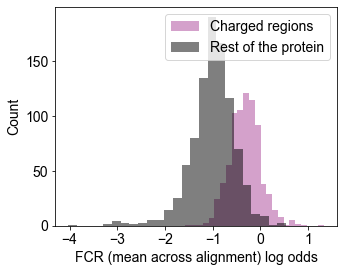

In [17]:
plt.figure(figsize=(5,4))
plt.hist(region_logodds, bins=24, alpha = 0.5, label = 'Charged regions', color=cscheme['cr'])
plt.hist(rest_logodds, bins=25, alpha = 0.5, color = cscheme['null'], label = 'Rest of the protein')
plt.xlabel("FCR (mean across alignment) log odds")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig('./plots/Figure3.4D.png', dpi=300)
plt.show()

In [18]:
stats.bartlett(region_logodds, rest_logodds)

BartlettResult(statistic=116.40563814840544, pvalue=3.873788906426837e-27)

In [19]:
stats.levene(region_logodds, rest_logodds, center="mean")

LeveneResult(statistic=48.38627259575412, pvalue=4.9718329594356096e-12)